<a href="https://colab.research.google.com/github/Nagaraj-gt/applications-artificial-intelligence/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART B (2) : Image Classification

***Using pretrained resnet18, densenet121, vgg19 models on this dataset, train a 15-class 
classification model and report per-class classification accuracy in terms of precision and 
recall. Submit q1.py. [10 marks]***



**TEAM MEMBERS:**

 Nagaraj G T	 12120095

 Yashaswi Singh	 12120064

 Madhab Chakraborty	 12120045

 Rama Gangadhar Durvasula	 12120087

 Parmarth matta	 12120077



In [1]:
from torchvision import datasets, models, transforms

In [2]:
# Pre=processing the input images to match images with what was presented during training period

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

In [ ]:
# Import Train and Test Images. The Assignment data is split into train (1 to 40) and validation (rest) sets manually and uploaded in GIT

!wget 'https://github.com/Nagaraj-gt/applications-artificial-intelligence/raw/main/dataset.zip'
!unzip dataset.zip


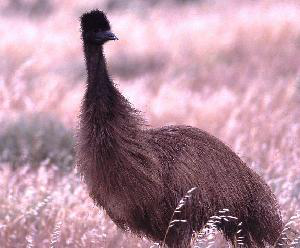

In [4]:
from PIL import Image
img = Image.open('/content/dataset/train/emu/image_0001.jpg')
display(img)

In [5]:
# Importing required libraries for training

import os
import torch

In [6]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


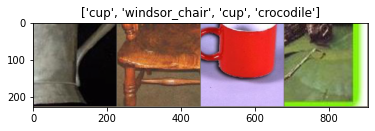

In [7]:
# Visualize few images
import torchvision
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Get a batch of validations data
test_inputs, test_classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Method to train pre-trained model with domain specific data
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Method to visualize Model Predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## RESNET MODEL 

## Approach 1: Initiate weights with pre trained values

Initiate the resnet model with pre-trained weights instead od random weights. Rest training to proceed as normal with given data set

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [11]:
# Load Pretrained ResNet Model and reset final fully connected Layer for training

res_model = models.resnet18(pretrained=True)
num_ftrs = res_model.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
res_model.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = res_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
# Train and Evaluate

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Epoch 0/4
----------
train Loss: 1.8631 Acc: 0.4333
val Loss: 0.3169 Acc: 0.9122

Epoch 1/4
----------
train Loss: 0.9288 Acc: 0.7200
val Loss: 0.2216 Acc: 0.9122

Epoch 2/4
----------
train Loss: 0.7369 Acc: 0.7950
val Loss: 0.2038 Acc: 0.9366

Epoch 3/4
----------
train Loss: 0.7338 Acc: 0.7850
val Loss: 0.1255 Acc: 0.9512

Epoch 4/4
----------
train Loss: 0.7697 Acc: 0.7683
val Loss: 0.2834 Acc: 0.9171

Training complete in 0m 36s
Best val Acc: 0.951220


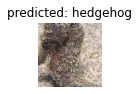

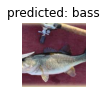

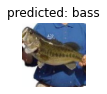

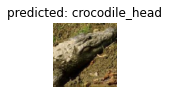

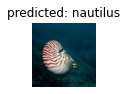

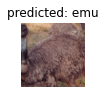

In [13]:
## Visualize Model

visualize_model(model_ft)

## Approach 2: Freeze the pre-trained weights except final fully connected layer

The weights of ResNet is freezed as per pre-trained weights. However the final fully connected layer is trained as per given data.

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [15]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 15)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
# Train and Evaluate

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.1364 Acc: 0.3633
val Loss: 0.6754 Acc: 0.8146

Epoch 1/4
----------
train Loss: 1.2924 Acc: 0.6417
val Loss: 0.3500 Acc: 0.8976

Epoch 2/4
----------
train Loss: 1.0521 Acc: 0.6967
val Loss: 0.2687 Acc: 0.9268

Epoch 3/4
----------
train Loss: 0.8967 Acc: 0.7183
val Loss: 0.1959 Acc: 0.9268

Epoch 4/4
----------
train Loss: 0.7468 Acc: 0.7883
val Loss: 0.2169 Acc: 0.9073

Training complete in 0m 18s
Best val Acc: 0.926829


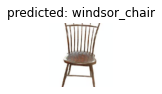

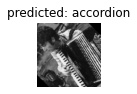

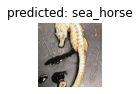

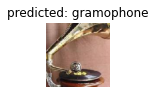

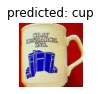

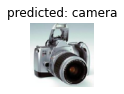

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [22]:
# Per class classification accuracy report in terms of precision and recall

nb_classes = 15

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)): 
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([ 7, 11,  4, 11])
tensor([13,  2, 14,  1])
tensor([ 6, 14,  8,  2])
tensor([2, 1, 9, 3])
tensor([1, 0, 4, 3])
tensor([10, 12,  0, 13])
tensor([ 7,  0, 14,  3])
tensor([12,  4, 11,  5])
tensor([13, 13,  0,  3])
tensor([12,  6, 10,  2])
tensor([ 9,  0,  5, 14])
tensor([3, 7, 2, 9])
tensor([ 7, 13, 10, 10])
tensor([ 0,  1,  5, 13])
tensor([12,  0,  1,  6])
tensor([10, 14,  1, 12])
tensor([8, 1, 7, 4])
tensor([14,  5,  2, 10])
tensor([11, 11,  7,  2])
tensor([ 5, 11,  4,  1])
tensor([ 9, 13,  9,  1])
tensor([0, 8, 5, 4])
tensor([6, 5, 8, 3])
tensor([11, 10,  6, 12])
tensor([13,  5,  5,  5])
tensor([ 0,  4,  6, 14])
tensor([11,  8, 11, 13])
tensor([ 0, 12,  9,  5])
tensor([14, 13, 13,  7])
tensor([1, 3, 9, 2])
tensor([13,  6, 14, 11])
tensor([ 7, 12,  4,  1])
tensor([ 9,  9, 10,  9])
tensor([ 5,  5, 14, 12])
tensor([12,  4, 12,  6])
tensor([ 6,  7, 12,  9])
tensor([ 3, 14, 10,  0])
tensor([3, 2, 9, 5])
tensor([ 9,  6, 12, 10])
tensor([ 5,  5,  8, 14])
tensor([4, 7, 1, 1])
tensor([13,

In [20]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([1.0000, 1.0000, 0.9000, 0.5000, 0.9091, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9412, 0.9412, 0.9375])


In [ ]:
# Recall Matrix

print(confusion_matrix.diag()/(confusion_matrix.diag() + )))

## Conclusion on ResNet

The Best value accuracy is around 95% if the approach 1 is considered. That is initializing the ResNet model with pre-trained weights and then training the model for given data.

## DENSENET121

## Approach followed is to Initiate weights with pre trained values as this is considered approach in above ResNet Model. 

This helps to better compare various models by singular approach.

In [ ]:
# Load Pretrained DenseNet Model and reset final fully connected Layer for training

densenet_model = models.densenet121(pretrained=True)
num_ftrs = densenet_model.classifier.in_features  
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
densenet_model.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = densenet_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Train and Evaluate

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

In [ ]:
## Visualize Model

visualize_model(model_ft)

CONCLUSION : Best value accuracy for DenseNet121 is about 91%. This is lesser when compared to ResNet18

## VGG 19 Model


In [ ]:
# Load Pretrained VGG Model and reset final fully connected Layer for training

vgg_model = models.vgg19(pretrained=True)
num_ftrs = vgg_model.classifier[0].in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
vgg_model.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = vgg_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Train and Evaluate

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

In [ ]:
## Visualize Model

visualize_model(model_ft)

CONCLUSION : The accuracy of VGG19 is about 72%. Compared to ResNet and DenseNet its pretty low. May be more epoch runs would have trained with better accuracies
